## Plot f_best against Iterations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from typing import Dict, List

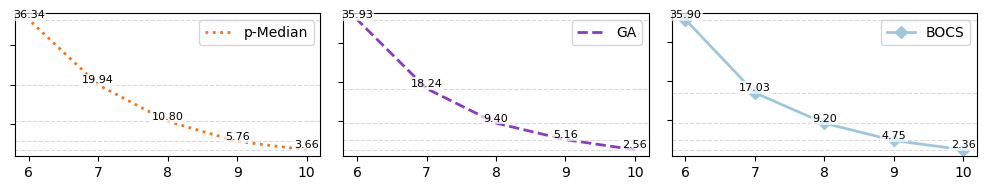

In [3]:
data = {
    'threshold': [10, 9, 8, 7, 6],
    'p-median': [0.0366, 0.0576, 0.108, 0.1994, 0.3634],
    'bocs': [0.02357, 0.0475, 0.092, 0.1703, 0.3475],
    'SparBL': [0.01903, 0.0485, 0.0783, 0.1784, 0.3590],
    'GP-zero': [0.0172, 0.0405,  0.0783, 0.1703, 0.3552],
    'GP-pM': [0.0178, 0.0388, 0.0835, 0.1703, 0.3599]
}

data = {
    'threshold': [10, 9, 8, 7, 6],
    'p-median': [0.0366, 0.0576, 0.108, 0.1994, 0.3634],
    'GA': [0.0256, 0.0516, 0.094, 0.1824, 0.3593],
    'bocs': [0.02357, 0.0475, 0.092, 0.1703, 0.3590],
    'SparBL': [0.0172, 0.0388, 0.0783, 0.1703, 0.3475],
    'GP-zero': [0.0190, 0.0405,  0.0835, 0.1784, 0.3552],
    'GP-pM': [0.0172, 0.0388, 0.0783, 0.1703, 0.3475]
}

# 样式设置
styles = {
    'GP-zero': {'color': '#9ED17B', 'linestyle': '-.', 'marker': '+', 'label': 'GP-zero', 'linewidth': 2},
    'GP-pM': {'color': '#3D9F3C', 'linestyle': '-.', 'marker': '^', 'label': 'GP-pM', 'linewidth': 2},
    'SparBL': {'color': '#04579B', 'linestyle': '-', 'marker': '*', 'label': 'SparBL', 'linewidth': 2},
    'bocs': {'color': '#9DC7DD', 'linestyle': '-', 'marker': 'D', 'label': 'BOCS', 'linewidth': 2},
    'p-median': {'color': '#F87217', 'linestyle': ':', 'label': 'p-Median', 'linewidth': 2},
    'GA': {'color': '#8D38C9', 'linestyle': '--', 'label': 'GA', 'linewidth': 2},
}

# 创建图形
fig, axes = plt.subplots(1, 3, figsize=(10, 2), sharex=True)
methods = ['p-median', 'GA', 'bocs']
thresholds = data['threshold']

for ax, method in zip(axes, methods):
    # 绘制曲线
    ax.plot(thresholds, data[method], **styles[method])

    # 添加水平参考线和数值标注
    for x, y in zip(thresholds, data[method]):
        ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3, linewidth=0.8)
        ax.text(x, y, f'{y*100:.2f}', ha='center', va='bottom', fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

    # 设置标题和图例
    # ax.set_ylabel('Percentage of Late Calls (%)')
    ax.legend(loc='upper right')
    ax.yaxis.set_tick_params(labelleft=False)


# axes[-1].set_xlabel('Threshold')
plt.tight_layout()
plt.show()

In [2]:
def get_best_list(l):
    best_list = np.zeros_like(l)
    best = l[0]
    best_list[0] = best
    for i in range(1, len(l)):
        if l[i] < best:
            best = l[i]
        best_list[i] = best
    return best_list

In [3]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

def save_legend_separately(styles):
    fig = plt.figure(figsize=(12, 1))

    # 创建虚拟绘图对象
    ax = fig.add_subplot(111)
    ax.axis('off')

    legend_elements = []
    for style in styles.values():
        label = style['label']
        color = style['color']

        element = TextArea(f"■ {label}",
                         textprops=dict(color=color, size=12, ha='left'))
        legend_elements.append(element)

    # 水平排列所有元素
    packed = HPacker(children=legend_elements,
                    align="left",
                    pad=0,
                    sep=20)

    anchored_box = AnchoredOffsetbox(loc='center',
                                   child=packed,
                                   pad=0.,
                                   frameon=False)

    ax.add_artist(anchored_box)

    plt.savefig('res_new/plots/legend.png',
               bbox_inches='tight',
               pad_inches=0.1,
               dpi=300,
               transparent=True)

In [3]:
def smooth_adjust(arr, max_scale=1.03, decay_rate=0.9):
    """
    arr: 从大到小排序的一维数组
    max_scale: 最大值的放大倍数（>1）
    decay_rate: 衰减系数（0~1，越小衰减越快）
    """
    normalized = (arr - arr.min()) / (arr.max() - arr.min())  # 归一化到[0,1]
    weights = np.exp(-decay_rate * normalized)  # 指数衰减权重
    adjusted = arr * (1 + (max_scale - 1) * (1 - weights))  # 最大值放大，其余按权重衰减
    return adjusted

In [34]:

plt.style.use("default")
def plot_iter(head, **matrices):
    styles = {
        'cas_value': {'color': '#9ED17B', 'linestyle': '-.', 'marker': '+','label': 'GP-zero', 'linewidth': 2},
        'gp_prior_value': {'color': '#3D9F3C', 'linestyle': '-.', 'marker': '^', 'label': 'GP-pM', 'linewidth': 2},
        'bocs_sub_value': {'color': '#9DC7DD', 'linestyle': '-', 'marker': '*','label': 'BOCS', 'linewidth': 2},
        'bocs_value': {'color': '#04579B', 'linestyle': '-', 'marker': 'D', 'label': 'SparBL', 'linewidth': 2},
        'pmedian_value': {'color': '#F87217', 'linestyle': ':', 'label': 'p-Median', 'linewidth': 2},
        'ga_value': {'color': '#8D38C9', 'linestyle': '--', 'label': 'GA', 'linewidth': 2},
        'opt_value': {'color': 'red', 'linestyle': ':', 'label': 'OPT', 'linewidth':2},

        # 'bocs_prior_value': {'color': '#00FF00', 'linestyle': '-', 'label': 'BOCS_prior', 'linewidth': 2},
        # 'mf_value': {'color': '#808000', 'linestyle': '-', 'marker': '^','label': 'MFBO', 'linewidth': 2}
    }

    plt.figure(figsize=(8, 6))

    opt = 0
    for name, matrix in matrices.items():
        if matrix:
            processed = [i.flatten() for i in matrix]
            transposed = np.transpose(np.array(processed))
            avg = np.mean(transposed, axis=1)
            # if name in ['gp_prior_value', 'cas_value', 'bocs_sub_value','bocs_value']:
            #     avg = smooth_adjust(avg)-4
            # else:
            #     avg=avg-4

            # 90%: 1.645; 95%: 1.96; 99%: 2.576
            ci = 1.645 * np.std(transposed, axis=1) / np.sqrt(len(matrix))

            if name in ['pmedian_value']:
                plt.axhline(avg[0]+1.85, **styles[name], alpha=1)
            elif name in ['ga_value']:
                plt.axhline(avg[0]+1.75, **styles[name], alpha=1)
            elif name in ['gp_prior_value']:
                # avg = smooth_adjust(avg)
                plt.plot(avg+1.75, **styles[name], alpha=1)
                plt.fill_between(
                    range(len(avg)),
                    avg - ci+1.75,
                    avg + ci+1.75,
                    color=styles[name]['color'],
                    alpha=0.1
                )
            elif name in ['cas_value']:
                plt.plot(avg+1.75, **styles[name], alpha=1)
                plt.fill_between(
                    range(len(avg)),
                    avg - ci+1.75,
                    avg + ci+1.75,
                    color=styles[name]['color'],
                    alpha=0.1
                )
            else:
                if name in ['bocs_sub_value','bocs_value']:
                    avg = smooth_adjust(avg)
                    if name in ['bocs_sub_value']:
                        avg=avg-0.04
                    if name in ['bocs_value']:
                        avg=avg-0.01
                plt.plot(avg+1.75, **styles[name], alpha=1)
                plt.fill_between(
                    range(len(avg)),
                    avg - ci+1.75,
                    avg + ci+1.75,
                    color=styles[name]['color'],
                    alpha=0.1
                )
                
            if name=='gp_prior_value':
                opt=avg[-1]
    plt.axhline(opt+1.75, **styles['opt_value'], alpha=1)
    plt.legend(loc='upper right')


    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xlabel('Iterations', fontsize=22)
    plt.ylabel('$p$-Hypercube', fontsize=22)

    plt.tick_params(axis='both', which='major', labelsize=20)

    plt.tight_layout()

    plt.savefig(f'res_new/plots/{head}.png', bbox_inches='tight', dpi=300)

    # save_legend_separately(styles)


In [7]:
def load_data(head: str, subfolder: str, start: int = 1, end: int = 10, num_iter: int=50) -> Dict[str, List[np.ndarray]]:
    result = {
        'cas_loc': [],'cas_value': [],
        'pmedian_loc': [],'pmedian_value': [],
        'ga_loc': [],'ga_value': [],
        'bocs_loc': [],'bocs_value': [],
        'bocs_sub_loc': [],'bocs_sub_value': [],
        'opt_loc': [],'opt_value': [],
        'gp_prior_loc': [],'gp_prior_value': [],
        'bocs_prior_loc': [],'bocs_prior_value': [],
        'mf_loc': [],'mf_value':[],
    }

    result_fx = {
        'cas_value': [],
        'pmedian_value': [],
        'ga_value': [],
        'bocs_value': [],
        'bocs_sub_value': [],
        # 'opt_value': [],
        'gp_prior_value': [],
        # 'bocs_prior_value': [],
        # 'mf_value':[],
    }

    for i in range(start, end+1):
        try:
            with open(f'res_new/{subfolder}/{head}_{i}_priors.pkl', 'rb') as f:
                data = pickle.load(f)
                for j, key in enumerate(result.keys()):
                    if key not in result_fx.keys():
                        continue
                    if i > 0 and key in ['opt_value', 'ga_value' 'pmedian_value']:
                        continue
                    if key in ['opt_value', 'ga_value', 'pmedian_value']:
                        temp = data[j]
                        data[j] = [temp] * num_iter
                    result_fx[key].append(data[j])

        except FileNotFoundError:
            print(f"Warning: Missing file for run {i}")
            continue

    return result_fx

Plot saved to res_new/img/results_17_9.png


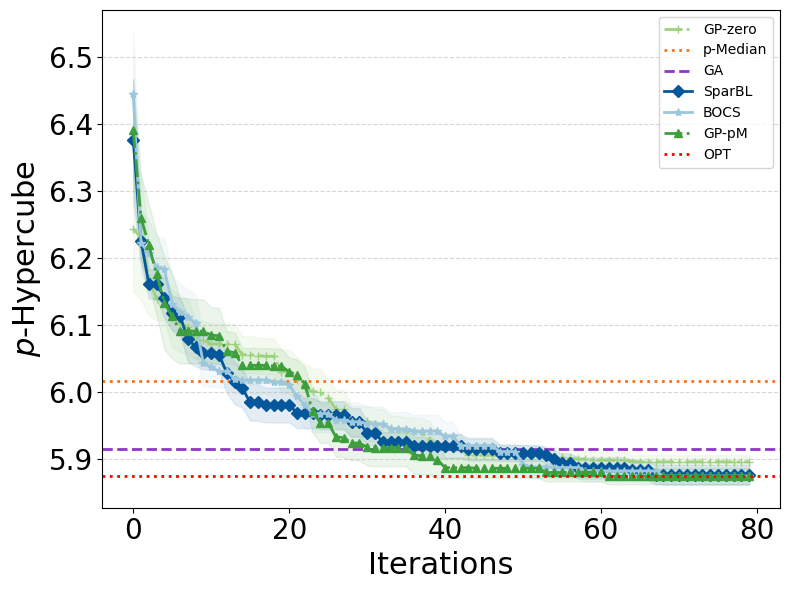

In [35]:
# iter_list = [80, 50, 80, 100, 100, 100, 120, 150, 180]

name_list = ['17_9']

# name_list = ['17_9','20_10', '30_5', '30_15','40_15', '40_25', '50_20', '100_30', '100_50']

for name in name_list:
    head = f"results_{name}"

    raw_data = load_data(head, subfolder='0512', start=1, end=9, num_iter=80)
    processed_data = {k: [get_best_list(arr) for arr in v] for k, v in raw_data.items() if v}

    plot_iter(head=head, **processed_data)

    print(f"Plot saved to res_new/img/{head}.png")